In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import clear_output

In [2]:
# Configuration
TICKER = "AMZN"  # Stock ticker symbol
SEQ_LENGTH = 60  # Sequence length for LSTM input
BATCH_SIZE = 32  # Batch size for training
EPOCHS = 100  # Number of training epochs
LEARNING_RATE = 0.002  # Learning rate for optimizer
HIDDEN_SIZE = 128
TRAIN_TEST_RATIO = 0.8  # Ratio of training to testing data
DROPOUT = 0.01
NUM_LAYERS = 3

In [3]:
# Download stock data
df = yf.download(TICKER, period="max", interval="1d", rounding=True, prepost=True)
df.dropna(inplace=True)
df["EMA"] = df["Close"].ewm(span=5, adjust=False).mean()
df.dropna(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
len(df)

7051

In [5]:
df

Price,Close,High,Low,Open,Volume,EMA
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,
Date,,,,,,
1997-05-15,0.10,0.12,0.10,0.12,1443120000,0.100000
1997-05-16,0.09,0.10,0.09,0.10,294000000,0.096667
1997-05-19,0.09,0.09,0.08,0.09,122136000,0.094444
1997-05-20,0.08,0.09,0.08,0.09,109344000,0.089630
1997-05-21,0.07,0.08,0.07,0.08,377064000,0.083086
...,...,...,...,...,...,...
2025-05-19,206.16,206.62,201.26,201.65,34314800,205.347726
2025-05-20,204.07,205.59,202.65,204.63,29470400,204.921817


In [6]:
# Normalize features
features = ["Close", "EMA"]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [7]:
# Prepare sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(seq_length, len(data)):
        xs.append(data[i - seq_length:i])
        ys.append(data[i, features.index("Close")])  # Predicting the 'Close' price
    return np.array(xs), np.array(ys)

In [8]:
X, y = create_sequences(scaled_data[-3000:], SEQ_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-TRAIN_TEST_RATIO, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader instances
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
# LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take the output from the last time step
        out = self.fc(out)
        return out

In [10]:
# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=len(features), hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Logging
train_loss_log = []
val_loss_log = []

# Early stopping
best_val_loss = float('inf')
patience = 200
counter = 0

for epoch in range(EPOCHS):
    model.train()
    batch_train_losses = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        batch_train_losses.append(loss.item())

    # Validation
    model.eval()
    batch_val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            batch_val_losses.append(loss.item())

    avg_train_loss = np.mean(batch_train_losses)
    avg_val_loss = np.mean(batch_val_losses)
    train_loss_log.append(avg_train_loss)
    val_loss_log.append(avg_val_loss)

    clear_output(wait=True)
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [100/100] | Train Loss: 0.000110 | Val Loss: 0.000339


In [11]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

Mean Absolute Error: 2.55
Root Mean Squared Error: 3.52


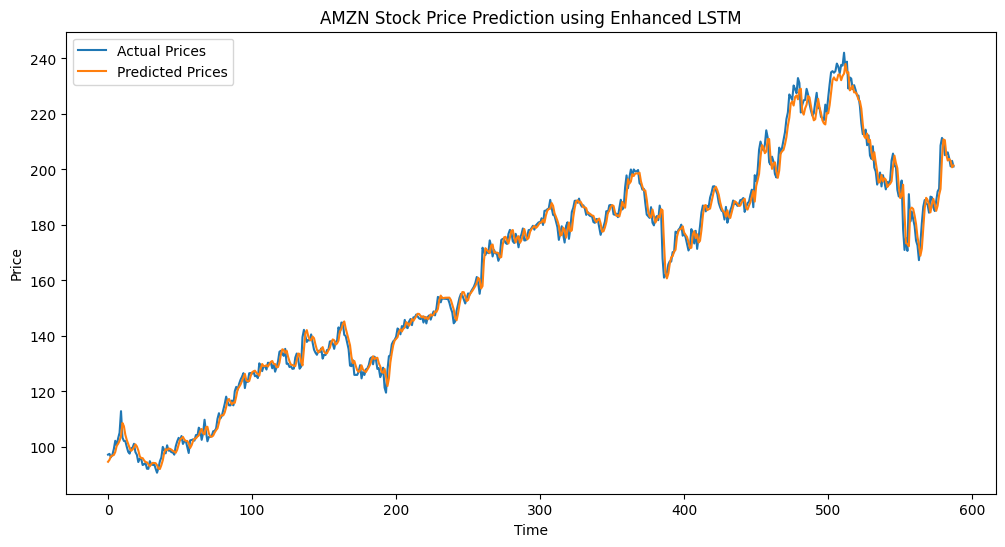

In [12]:
# Evaluation
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).squeeze().cpu().numpy()
        predictions.extend(outputs)
        actuals.extend(y_batch.numpy())

# Inverse transform predictions and actuals
predictions = np.array(predictions)
actuals = np.array(actuals)
zeros = np.zeros((len(predictions), len(features)))
zeros[:, features.index("Close")] = predictions
predictions_inverse = scaler.inverse_transform(zeros)[:, features.index("Close")]

zeros[:, features.index("Close")] = actuals
actuals_inverse = scaler.inverse_transform(zeros)[:, features.index("Close")]

# Calculate evaluation metrics
mae = mean_absolute_error(actuals_inverse, predictions_inverse)
rmse = np.sqrt(mean_squared_error(actuals_inverse, predictions_inverse))
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(actuals_inverse, label="Actual Prices")
plt.plot(predictions_inverse, label="Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title(f"{TICKER} Stock Price Prediction using Enhanced LSTM")
plt.legend()
plt.show()

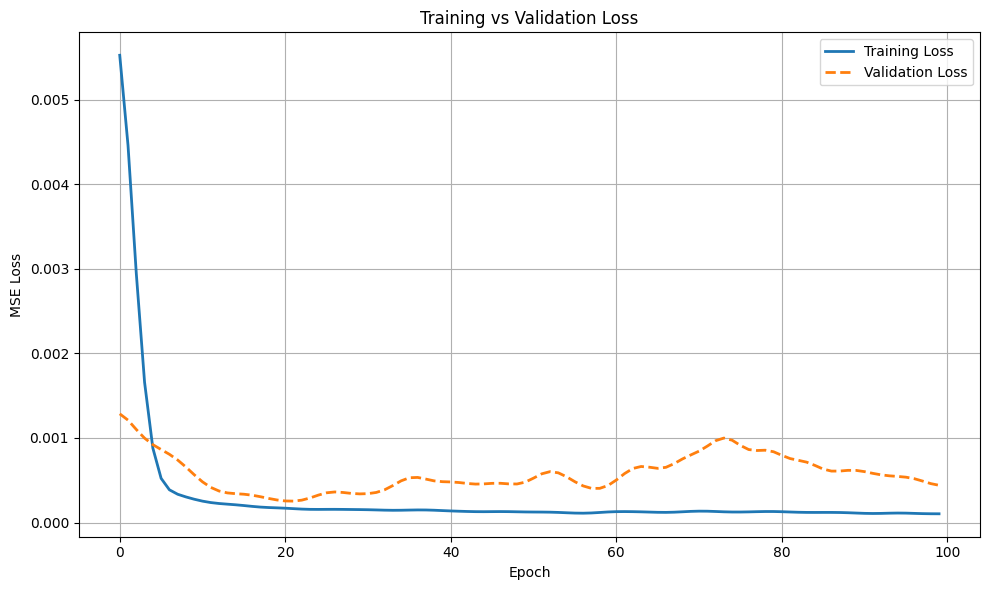

In [13]:
from scipy.ndimage import gaussian_filter1d

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    smoothed_train = gaussian_filter1d(train_losses, sigma=2)
    smoothed_val = gaussian_filter1d(val_losses, sigma=2)

    plt.plot(smoothed_train, label='Training Loss', linewidth=2)
    plt.plot(smoothed_val, label='Validation Loss', linewidth=2, linestyle='--')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_curves(train_loss_log, val_loss_log)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Function to analyze prediction errors
def analyze_errors(actual, predicted, model_name=""):
    errors = actual - predicted
    plt.figure(figsize=(12, 10))

    # Error distribution with normal curve
    plt.subplot(2, 2, 1)
    count, bins, ignored = plt.hist(errors, bins=50, density=True, alpha=0.6, color='g')

    # Fit normal distribution
    mu, std = norm.fit(errors)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x, p, 'k', linewidth=2)
    plt.xlabel('Error')
    plt.ylabel('Density')
    plt.title(f'{model_name} Error Distribution\nNormal Fit: μ={mu:.2f}, σ={std:.2f}')
    plt.grid(True)

In [15]:
# Scatter plot to show correlation between actual and predicted values
def scatter_actual_vs_predicted(actual, predicted, model_name=""):
    plt.figure(figsize=(8, 6))
    plt.scatter(actual, predicted, alpha=0.5)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{model_name} Actual vs Predicted Scatter Plot')
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red')  # y = x line
    plt.grid(True)
    plt.show()

Linear Regression MAE:  2.39
Linear Regression RMSE: 3.34


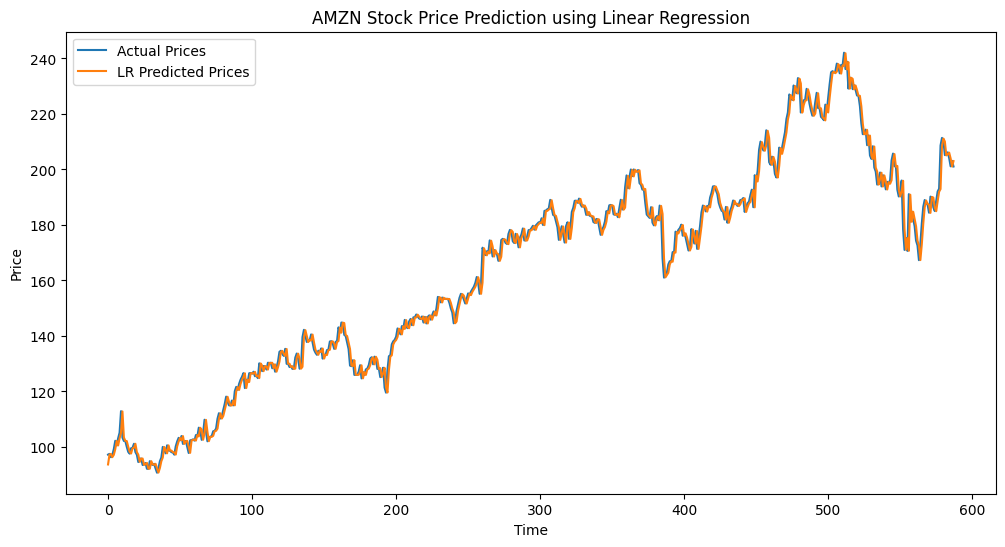

In [16]:
# Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Use only the last time‐step of each sequence as features
X_lr_train = X_train[:, -1, :]  # shape: (n_samples, n_features)
X_lr_test  = X_test[:, -1, :]

# Train and predict
lr_model = LinearRegression()
lr_model.fit(X_lr_train, y_train)
lr_preds_scaled = lr_model.predict(X_lr_test)

# Inverse‐transform scaled predictions and true values
zeros = np.zeros((len(lr_preds_scaled), len(features)))
zeros[:, features.index("Close")] = lr_preds_scaled
lr_preds = scaler.inverse_transform(zeros)[:, features.index("Close")]

zeros[:, features.index("Close")] = y_test
lr_actuals = scaler.inverse_transform(zeros)[:, features.index("Close")]

# Compute and print metrics
lr_mae  = mean_absolute_error(lr_actuals, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(lr_actuals, lr_preds))
print(f"Linear Regression MAE:  {lr_mae:.2f}")
print(f"Linear Regression RMSE: {lr_rmse:.2f}")

# --- Plot Linear Regression Predictions vs Actual Prices ---

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(lr_actuals, label="Actual Prices")
plt.plot(lr_preds, label="LR Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title(f"{TICKER} Stock Price Prediction using Linear Regression")
plt.legend()
plt.show()

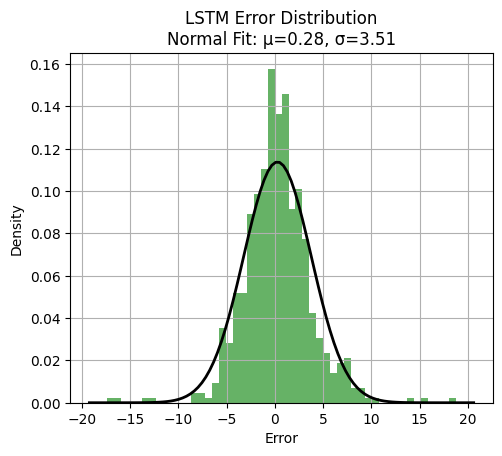

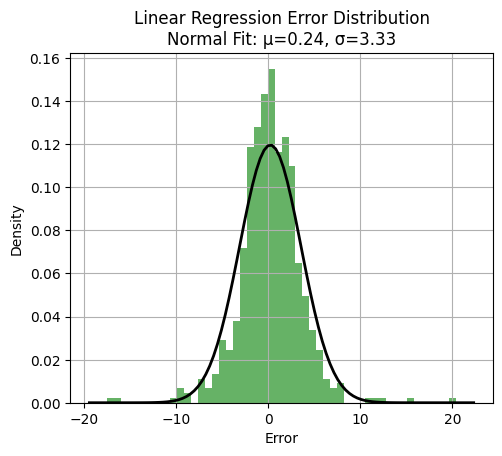

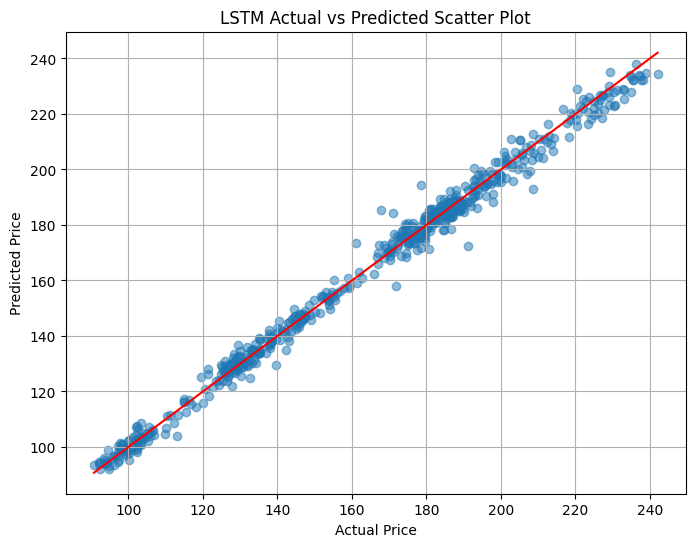

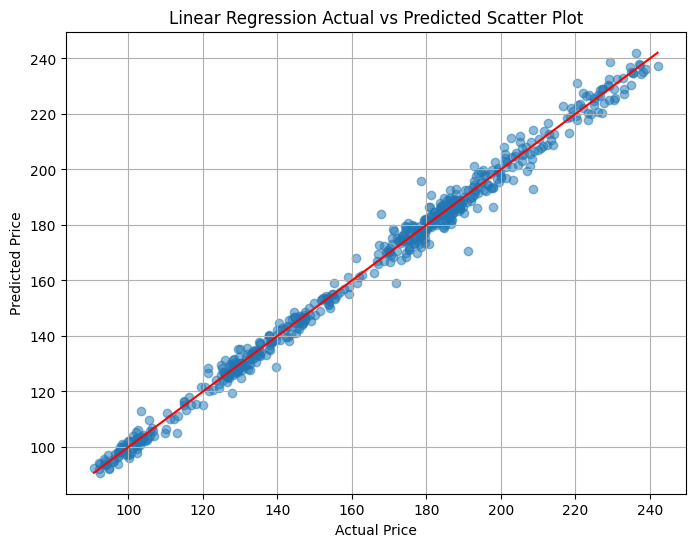

In [17]:
analyze_errors(actuals_inverse, predictions_inverse, "LSTM")
analyze_errors(lr_actuals, lr_preds, "Linear Regression")

scatter_actual_vs_predicted(actuals_inverse, predictions_inverse, "LSTM")
scatter_actual_vs_predicted(lr_actuals, lr_preds, "Linear Regression")